<a href="https://colab.research.google.com/github/bradleywjenks/CIVE_70019_70057/blob/main/notebooks/optimal_reservoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal reservoir operation


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

Initialise module GitHub repository.

In [17]:
# Run this cell once
%%capture
import sys
import os

if 'google.colab' in sys.modules:
  !git clone https://github.com/bradleywjenks/CIVE_70019_70057.git

In [18]:
# Load packages
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import warnings
warnings.filterwarnings('ignore')

# Improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

### Problem formulation

We consider an example of reservoir operation optimisation problem, using a simplified (and convex) model.

The system has a single reservoir, a single release, and a single demand point.

* $I_t $ is the reservoir inflow at time $t \in \{0,\ldots,T-1\}$ (**known** in advance)
* $S_{\text{cap}}$ is the storage capacity (**known** in advance)
* $S_0$ is the initial storage level (**known** in advance)
* $d_t$ is the water demand at time $t \in \{0,\ldots,T-1\}$ (**known** in advance)
* $S_t$ is the reservoir storage at time $t \in \{0,\ldots,T-1\}$ (**state** variable)
* $u_t$ is the reservoir release at time $t \in \{0,\ldots,T-1\}$ (first **control** variable)
* $w_t$ is the reservoir spill at time $t \in \{0,\ldots,T-1\}$ (second **control** variable)     

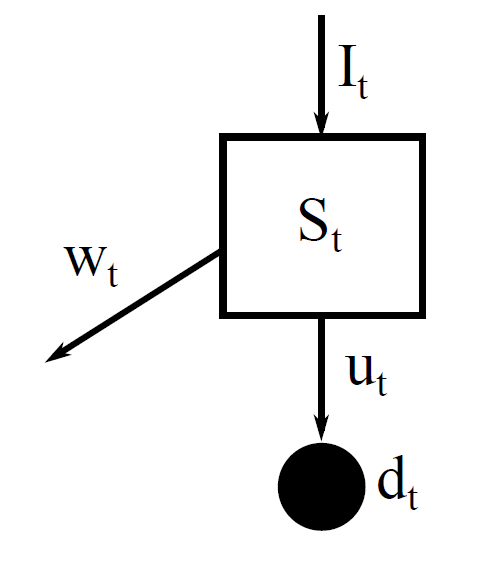

In [19]:
# Problem figure
from IPython.display import Image, display
figure_dir = '/content/CIVE_70019_70057/data/figures/image1.png'
display(Image(filename=figure_dir))

Our objective is to minimise the differences between water demand and realease. We also want to promote similarity between final and initial storage level, to aid re-implementation of the computed control settings (we assume the demand to be periodic).

$$\sum_{t=0}^{T-1}(u_t-d_t)^2 + (S_T-S_0)^2$$

The optimization is subject to constraints modelling mass balance:

$$S_{t+1} = S_t + I_t - u_t - w_t, \quad t=0,\ldots,T-1$$

and constraints modelling physical requirements:

$$0 \leq w_t ,\quad t \in \{0,\ldots,T-1\} $$
$$0 \leq S_t \leq S_{cap} ,\quad t \in \{0,\ldots,T-1\} $$
$$0 \leq u_t \leq d_{t},\quad t \in \{0,\ldots,T-1\} $$

In the following we show how this problem is solved using CVXPY.

In [20]:
# load data from .mat files
data_dir = '/content/CIVE_70019_70057/data/optimal_reservoir/'
data_name = 'reservoir_data.mat'
data = scipy.io.loadmat(os.path.join(data_dir, data_name))

I = data['I'].T[0] # reservoir inflow at time t
d = data['d'].T[0] # water demand at time t
S_cap =  data['S_cap'][0][0] # reservoir storage capacity
S_ini =  data['S_ini'][0][0] # initial storage level
T =  data['T'][0][0] # time steps

In [21]:
## define variables
S = cp.Variable(T+1) # storage
u = cp.Variable(T) # release
w = cp.Variable(T) # spillage

# Define objective function
cost = cp.sum_squares(u - d) + (S[T] - S[0])**2
objective = cp.Minimize( cost )

# Define constraints
constraint1 = [S[0] == S_ini]

constraint2 = []
constraint3 = []
constraint4 = []
constraint5 = []

for t in range(T):
    constraint2 += [S[t+1] == S[t] + I[t] - u[t] - w[t] ]
    constraint3 += [w[t] >= 0]
    constraint4 += [S[t] >= 0, S[t] <= S_cap]
    constraint5 += [u[t] >= 0, u[t] <= d[t]]

constraints = constraint1 + constraint2 + constraint3 + constraint4 + constraint5

## Pass the problem to cvxpy
prob = cp.Problem(objective,constraints)

# Compute optimal objective value
obj_value = prob.solve(verbose = True)

# Print the optimal objetive values
print(obj_value)
# The optimal value for S is stored in `S.value`.
#print(S.value)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 27 11:19:40 AM: Your problem has 1561 variables, 3121 constraints, and 0 parameters.
(CVXPY) Aug 27 11:19:40 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 27 11:19:40 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 27 11:19:40 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 27 11:19:41 AM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 27 11:19:41 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStu

We display the results below.

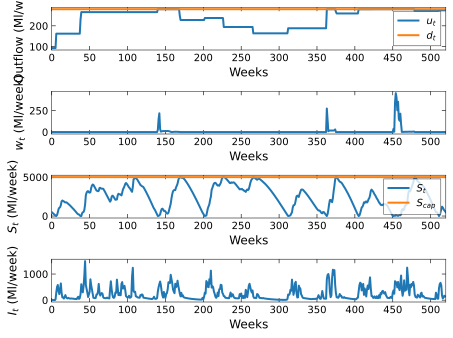

In [22]:
from matplotlib import rc
rc('text', usetex=False)

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, axs = plt.subplots(4, 1)
axs[0].plot(u.value, linewidth=2,label=r'$u_t$')
axs[0].plot(d, linewidth=2, label=r'$d_t$')
axs[0].set_xlabel('Weeks')
axs[0].set_ylabel('Outflow (Ml/week)')
leg = axs[0].legend(loc='right',edgecolor='k',borderpad=0.5,fancybox=False)
leg.get_frame().set_linewidth(0.5)

axs[1].plot(w.value, linewidth=2)
axs[1].set_xlabel('Weeks')
axs[1].set_ylabel(r'$w_t$ (Ml/week)')

axs[2].plot(S.value, linewidth=2,label=r'$S_t$')
axs[2].plot(S_cap * np.ones([np.size(S)]), linewidth=2, label=r'$S_{cap}$')
axs[2].set_xlabel('Weeks')
axs[2].set_ylabel(r'$S_t$ (Ml/week)')
leg = axs[2].legend(loc='right',edgecolor='k',borderpad=0.5,fancybox=False)
leg.get_frame().set_linewidth(0.5)

axs[3].plot(I, linewidth=2)
axs[3].set_xlabel('Weeks')
axs[3].set_ylabel(r'$I_t$ (Ml/week)')

for i in range(4):
    axs[i].set_xlim([0,T])
    #axs[i].set_ylim(bottom=0)
    axs[i].set_xticks(np.arange(0, T, 50))
    axs[i].tick_params(axis="both", direction="in", length=4, width=0.6)
    axs[i].tick_params(right=True, top=True, labelright=False, labeltop=False,rotation=0)
    for axis in ['top','bottom','left','right']:
        axs[i].spines[axis].set_linewidth(0.5)

fig.tight_layout()
plt.show()

Comment on the optimal reservoir operation results. Is demand met at all times? If not, what actions would need to be taken?

Enter responses below:
*   List item
*   List item
*   List item